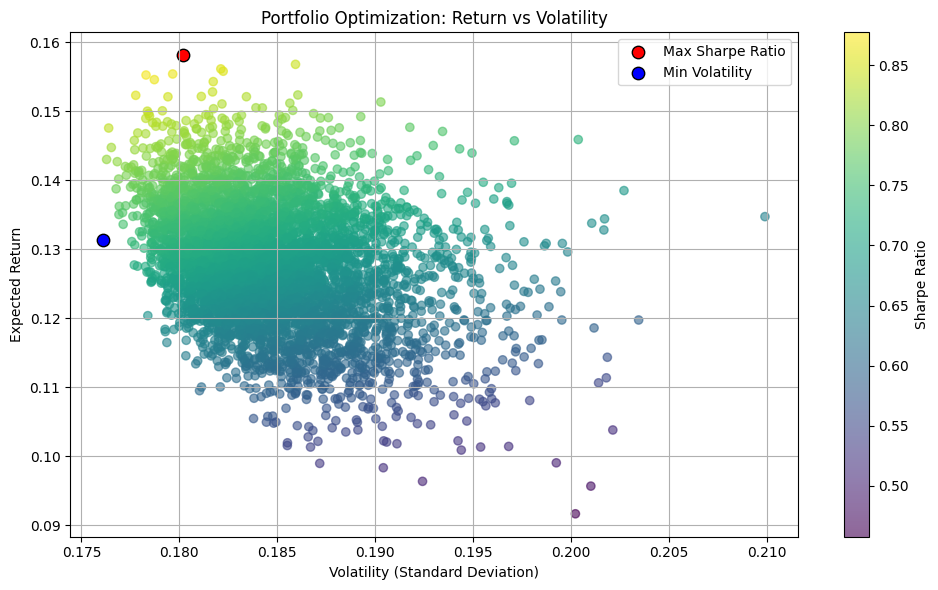

In [1]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(42)
num_assets = 10
num_portfolios = 5000


mean_returns = np.random.uniform(0.05, 0.20, num_assets)
cov_matrix = np.random.uniform(0.01, 0.05, (num_assets, num_assets))
cov_matrix = (cov_matrix + cov_matrix.T) / 2 
np.fill_diagonal(cov_matrix, np.random.uniform(0.02, 0.10, num_assets))


results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    weights_record.append(weights)
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    results[0, i] = portfolio_return
    results[1, i] = portfolio_std_dev
    results[2, i] = portfolio_return / portfolio_std_dev 


max_sharpe_idx = np.argmax(results[2])
min_vol_idx = np.argmin(results[1]) 


plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap="viridis", alpha=0.6)
plt.colorbar(label="Sharpe Ratio")
plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], color="red", label="Max Sharpe Ratio", edgecolors="black", s=80)
plt.scatter(results[1, min_vol_idx], results[0, min_vol_idx], color="blue", label="Min Volatility", edgecolors="black", s=80)
plt.title("Portfolio Optimization: Return vs Volatility")
plt.xlabel("Volatility (Standard Deviation)")
plt.ylabel("Expected Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [1]:
import sys
import os

repo_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_path)

import pandas as pd
from src.portfolio_maker import HRP, IVP, MVP, ASRP
import numpy as np
from scipy.cluster.hierarchy import linkage
import matplotlib.pyplot as plt
import os


df = pd.read_csv(os.path.join('..','data','binance_usdt_pairs_2018-12-31_2024-01-01_1d.csv'))
df['close'] = pd.to_numeric(df['close'])
df["open_time"] = pd.to_datetime(df["open_time"])
df["returns"] = df.groupby("symbol")["close"].pct_change()
df.head()

,symbol,open_time,open,high,low,close,volume,close_time,quote_volume,num_trades,taker_base_vol,taker_quote_vol,ignore,returns
0,BTCUSDT,2019-01-01,3701.23,3810.16,3642.00,3797.14,23741.687033,2019-01-01 23:59:59.999,8.814925e+07,154227,12919.155899,4.797344e+07,0,NaN
1,BTCUSDT,2019-01-02,3796.45,3882.14,3750.45,3858.56,35156.463369,2019-01-02 23:59:59.999,1.338766e+08,218538,17921.600114,6.827790e+07,0,0.016175
2,BTCUSDT,2019-01-03,3857.57,3862.74,3730.00,3766.78,29406.948359,2019-01-03 23:59:59.999,1.116574e+08,199812,14793.083267,5.617250e+07,0,-0.023786
3,BTCUSDT,2019-01-04,3767.20,3823.64,3703.57,3792.01,29519.554671,2019-01-04 23:59:59.999,1.110346e+08,192232,15579.303258,5.861620e+07,0,0.006698
4,BTCUSDT,2019-01-05,3790.09,3840.99,3751.00,3770.96,30490.667751,2019-01-05 23:59:59.999,1.158935e+08,203673,14908.914175,5.666746e+07,0,-0.005551


In [2]:
# Filter symbols with NaN values after '2023-01-01'
filter_date = pd.Timestamp("2023-01-01")
filtered_symbols = df[df["open_time"] > filter_date].groupby("symbol")["returns"].apply(
    lambda x: x.isna().any()
)
symbols_to_exclude = filtered_symbols[filtered_symbols].index
filtered_df = df[~df["symbol"].isin(symbols_to_exclude)]
filtered_returns_matrix = filtered_df.pivot_table(
    index="open_time", 
    columns="symbol", 
    values="returns"
)

In [9]:
filtered_returns_matrix_post_2023 = filtered_returns_matrix.loc[filtered_returns_matrix.index > filter_date].dropna(axis=1)
filtered_returns_matrix_post_2023.drop('EURUSDT', axis=1, inplace=True)

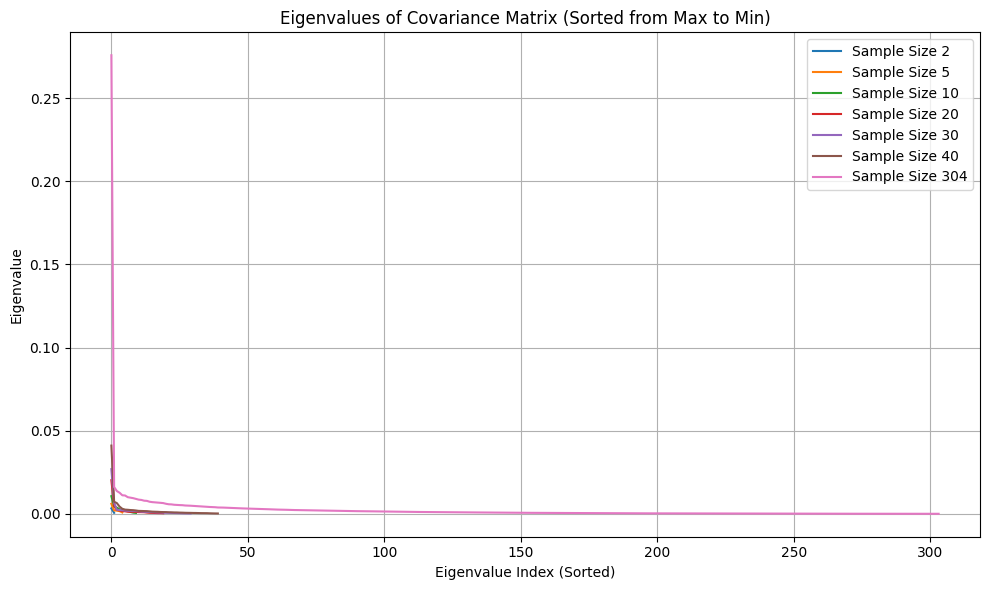

In [10]:
sample_sizes = [2, 5, 10 ,20 ,30 ,40 ,len(filtered_returns_matrix_post_2023.columns)]


def calculate_eigenvalues(dataframe, sample_size):
    sampled_symbols = np.random.choice(dataframe.columns, sample_size, replace=False)
    covariance_matrix = dataframe[sampled_symbols].cov()
    eigenvalues = np.linalg.eigvalsh(covariance_matrix)
    return np.sort(eigenvalues)[::-1] 


eigenvalues_data = {size: [] for size in sample_sizes}

for size in sample_sizes:
    eigenvalues = calculate_eigenvalues(filtered_returns_matrix_post_2023, size)
    eigenvalues_data[size] = eigenvalues


plt.figure(figsize=(10, 6))
for size, eigenvalues in eigenvalues_data.items():
    plt.plot(eigenvalues, label=f"Sample Size {size}")

plt.title("Eigenvalues of Covariance Matrix (Sorted from Max to Min)")
plt.xlabel("Eigenvalue Index (Sorted)")
plt.ylabel("Eigenvalue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
